***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#6' style="text-decoration : none; color : #000000;">5. Comparing Results</a></h2>  
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [22]:
df=pd.read_csv('Html.csv')
df.drop(['Unnamed: 0','Malicious'],axis=1,inplace=True)

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'functions' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_absolute,a_href_ftp,a_href_http,a_href_https,a_href_irc,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,...,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,progress_count,q_count,s_count,samp_count,script_async

Shape of our dataset: (43491, 1466)


#### Let us analyze the balance of classes

In [23]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [24]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        print(col)
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1466)


In [25]:
# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: Series([], dtype: object)


#### Check for missing data

In [26]:
df.isnull().sum()

a_charset_utf-8                                          0
a_count                                                  0
a_download_download                                      0
a_hidden_true                                            0
a_href_.7z                                               0
a_href_.apk                                              0
a_href_.app                                              0
a_href_.asp                                              0
a_href_.aspx                                             0
a_href_.au                                               0
a_href_.avi                                              0
a_href_.b                                                0
a_href_.bin                                              0
a_href_.br                                               0
a_href_.bz2                                              0
a_href_.ca                                               0
a_href_.cat                                             

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [27]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

1297 columns have more than 95% same values


In [28]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [32]:
columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()+['Target']

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [30]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
number_of_cookies,-0.353783,0.000000e+00,-160.283513,0.000000e+00
number_of_unsecure_cookies,-0.349525,0.000000e+00,-157.732419,0.000000e+00
number_of_non_http_only_cookies,-0.338537,0.000000e+00,-153.835747,0.000000e+00
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_absolute,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [33]:
columns.remove('Target')
print("Features we will be using:")
columns=num_stats_js[0:50].index.values
display(columns.tolist())

Features we will be using:


['number_of_cookies',
 'number_of_unsecure_cookies',
 'number_of_non_http_only_cookies',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_relative',
 'a_href_absolute',
 'a_href_out_of_domain',
 'img_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_https',
 'img_src_absolute',
 'img_src_relative',
 'img_src_https',
 'iframe_src_absolute',
 'iframe_src_relative',
 'link_rel_shortcut icon',
 'iframe_src_https',
 'a_href_https',
 'link_href_.ico',
 'link_count',
 'link_href_relative',
 'link_href_absolute',
 'link_rel_stylesheet',
 'number_of_http_only_cookies',
 'img_src_.jpg',
 'link_rel_icon',
 'img_src_out_of_domain',
 'link_href_.png',
 'link_href_.css',
 'ul_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_image/x-icon',
 'link_rel_manifest',
 'iframe_sr

In [34]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [35]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [36]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [37]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.878995171304
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29447   255    29702
True        3955  1135     5090
__all__    33402  1390    34792

Accuracy of the KNN model for twst data is: 0.875158064145
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7340    72     7412
True        1014   273     1287
__all__     8354   345     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.872212002759
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26378  3324    29702
True        1122  3968     5090
__all__    27500  7292    34792

Accuracy of the Logistic Regression model for twst data is: 0.87262903782
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6593   819     7412
True         289   998     1287
__all__     6882  1817     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.906041618763
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26583  3119    29702
True         150  4940     5090
__all__    26733  8059    34792

Accuracy of the Random Forest Classifier for twst data is: 0.897689389585
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6646   766     7412
True         124  1163     1287
__all__     6770  1929     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.879426304898
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26295  3407    29702
True         788  4302     5090
__all__    27083  7709    34792

Accuracy of the Ada Boost Classifier for twst data is: 0.879296470859
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6583   829     7412
True         221  1066     1287
__all__     6804  1895     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.892216601518
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26547  3155    29702
True         595  4495     5090
__all__    27142  7650    34792

Accuracy of the Gradient Boosting Classifier for twst data is: 0.891941602483
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6647   765     7412
True         175  1112     1287
__all__     6822  1877     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.907881122097
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26593  3109    29702
True          96  4994     5090
__all__    26689  8103    34792

Accuracy of the Extra Tree Classifier for twst data is: 0.897229566617
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6650   762     7412
True         132  1155     1287
__all__     6782  1917     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.905984134284
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26589  3113    29702
True         158  4932     5090
__all__    26747  8045    34792

Accuracy of the Bagging model for twst data is: 0.897114610875
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6644   768     7412
True         127  1160     1287
__all__     6771  1928     8699



Neural Network-1
The accuracy of the model on training data is: 0.894630949644


Predicted  False  True  __all__
Actual                         
False      26256  3446    29702
True         220  4870     5090
__all__    26476  8316    34792

The accuracy of the model on test data is: 0.884699390735


Predicted  False  True  __all__
Actual                         
False       6535   877     7412
True         126  1161     1287
__all__     6661  2038     8699

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [38]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [39]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.878995,1135.0,29447.0,255.0,3955.0,0.008585,0.777014
LogisticRegression,0.872212,3968.0,26378.0,3324.0,1122.0,0.111912,0.220432
RandomForestClassifier,0.906042,4940.0,26583.0,3119.0,150.0,0.105010,0.029470
AdaBoostClassifier,0.879426,4302.0,26295.0,3407.0,788.0,0.114706,0.154813
GradientBoostingClassifier,0.892217,4495.0,26547.0,3155.0,595.0,0.106222,0.116896
ExtraTreeClassifier,0.907881,4994.0,26593.0,3109.0,96.0,0.104673,0.018861
BaggingClassifier,0.905984,4932.0,26589.0,3113.0,158.0,0.104808,0.031041
Neural Network-1,0.894631,4870.0,26256.0,3446.0,220.0,0.116019,0.043222


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.875158,273.0,7340.0,72.0,1014.0,0.009714,0.787879,0.601204
LogisticRegression,0.872629,998.0,6593.0,819.0,289.0,0.110496,0.224553,0.832475
RandomForestClassifier,0.897689,1163.0,6646.0,766.0,124.0,0.103346,0.096348,0.900153
AdaBoostClassifier,0.879296,1066.0,6583.0,829.0,221.0,0.111846,0.171717,0.858219
GradientBoostingClassifier,0.891942,1112.0,6647.0,765.0,175.0,0.103211,0.135975,0.880407
ExtraTreeClassifier,0.897230,1155.0,6650.0,762.0,132.0,0.102806,0.102564,0.897315
BaggingClassifier,0.897115,1160.0,6644.0,768.0,127.0,0.103616,0.098679,0.898853
Neural Network-1,0.884699,1161.0,6535.0,877.0,126.0,0.118322,0.097902,0.898853


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [40]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [42]:
df.reset_index(inplace=True)

columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [43]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 43491, Columns: 51]
  Relationships:
    No relationships

In [44]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 16.089 seconds
Elapsed: 01:03 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [45]:
feature_matrix_sessions.head()

,number_of_cookies,number_of_unsecure_cookies,number_of_non_http_only_cookies,script_src_.js,script_count,script_src_relative,script_src_absolute,script_src_https,script_async_true,link_rel_canonical,div_count,script_type_text/javascript,script_src_out_of_domain,iframe_count,a_count,a_href_relative,a_href_absolute,a_href_out_of_domain,img_count,meta_http-equiv_X-UA-Compatible,link_href_https,img_src_absolute,img_src_relative,img_src_https,iframe_src_absolute,iframe_src_relative,link_rel_shortcut icon,iframe_src_https,a_href_https,link_href_.ico,link_count,link_href_relative,link_href_absolute,link_rel_stylesheet,number_of_http_only_cookies,img_src_.jpg,link_rel_icon,img_src_out_of_domain,link_href_.png,link_href_.css,ul_count,li_count,link_href_out_of_domain,link_type_image/x-icon,link_rel_manifest,iframe_src_.html,span_count,iframe_src_out_of_domain,form_action_relative,img_src_.png,link_href_out_of_domain + script_src_out_of_domain,img_src_https + link_href_out_of_domain,form_action_relative + script_async_true,script_src_absolute + script_src_out_of_domain,img_count + img_src_https,iframe_count + number_of_cookies,iframe_src_out_of_domain + img_src_.png,link_rel_canonical + number_of_unsecure_cookies,img_count + img_src_.png,img_count + img_src_relative,a_href_relative + link_href_.css,link_rel_shortcut icon + number_of_cookies,iframe_src_https + link_href_.png,form_action_relative + img_src_.jpg,img_src_.jpg + number_of_unsecure_cookies,iframe_src_out_of_domain + img_src_relative,number_of_unsecure_cookies + script_src_absolute,a_count + script_src_https,form_action_relative + link_type_image/x-icon,img_src_relative + li_count,iframe_src_out_of_domain + script_src_.js,link_href_https + script_async_true,iframe_src_out_of_domain + number_of_cookies,number_of_unsecure_cookies + script_type_text/javascript,a_href_absolute + a_href_out_of_domain,link_href_absolute + link_href_relative,link_href_absolute + link_rel_stylesheet,form_action_relative + link_rel_shortcut icon,img_src_.png + link_rel_canonical,link_href_relative + number_of_unsecure_cookies,link_rel_shortcut icon + number_of_http_only_cookies,form_action_relative + iframe_src_absolute,link_href_.png + script_count,number_of_cookies + script_src_absolute,meta_http-equiv_X-UA-Compatible + script_count,img_src_.png + script_type_text/javascript,script_src_https + span_count,img_src_relative + ul_count,iframe_src_https + img_src_relative,img_src_https + script_src_out_of_domain,a_href_out_of_domain + div_count,link_type_image/x-icon + script_src_.js,a_href_out_of_domain + number_of_non_http_only_cookies,img_src_https + link_href_.ico,link_type_image/x-icon + ul_count,a_href_absolute + img_src_.jpg,a_count + a_href_out_of_domain,img_src_.png + script_src_.js,img_src_out_of_domain + link_href_.ico,a_href_relative + link_count,link_rel_icon + script_src_relative,link_rel_canonical + script_type_text/javascript,link_rel_icon + number_of_cookies,number_of_cookies + number_of_non_http_only_cookies,li_count + script_async_true,a_count + link_href_https,form_action_relative + script_src_relative,div_count + li_count,iframe_src_https + img_src_out_of_domain,iframe_src_.html + link_count,link_href_out_of_domain + number_of_unsecure_cookies,link_href_absolute + script_src_out_of_domain,a_href_absolute + script_src_.js,a_href_https + link_href_https,script_count + script_type_text/javascript,iframe_src_.html + link_type_image/x-icon,div_count + form_action_relative,div_count + script_src_.js,img_src_https + number_of_unsecure_cookies,meta_http-equiv_X-UA-Compatible + script_src_absolute,link_rel_icon + link_rel_stylesheet,iframe_src_.html + link_href_out_of_domain,iframe_src_relative + link_href_.png,number_of_cookies + script_src_relative,script_count + span_count,img_src_.jpg + script_src_https,img_src_.jpg + ul_count,a_href_https + link_rel_stylesheet,span_count + ul_count,a_href_https + link_href_relative,link_rel_manifest + link_type_image/x-icon,number_of_cookies + script_type

In [46]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [47]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [48]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [49]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [50]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [51]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [52]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [57]:
X=fs[feature_selection_df[feature_selection_df.Total>=2]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43491, 78)

In [58]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['number_of_http_only_cookies + number_of_unsecure_cookies',
 'script_src_.js / script_count',
 'script_async_true / script_count',
 'link_rel_shortcut icon + number_of_unsecure_cookies',
 'link_href_out_of_domain / link_count',
 'script_type_text/javascript / script_count',
 'script_src_relative / script_src_absolute',
 'script_src_relative / script_count',
 'script_src_out_of_domain / script_src_relative',
 'script_src_out_of_domain / script_src_absolute',
 'script_src_https / script_src_relative',
 'script_src_https / script_src_absolute',
 'script_src_https / script_count',
 'script_src_absolute / script_src_relative',
 'script_src_absolute / script_count',
 'script_src_.js / script_src_relative',
 'script_src_.js / script_src_absolute',
 'number_of_unsecure_cookies / number_of_non_http_only_cookies',
 'number_of_unsecure_cookies / number_of_cookies',
 'number_of_unsecure_cookies + script_src_.js',
 'number_of_non_http_only_cookies / number_of_cookies',
 'number_of_non_http_only_co

In [59]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [60]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.892590250632
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26453  3248    29701
True         489  4602     5091
__all__    26942  7850    34792

Accuracy of the KNN model for twst data is: 0.888837797448
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6591   822     7413
True         145  1141     1286
__all__     6736  1963     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.881869395263
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26367  3334    29701
True         776  4315     5091
__all__    27143  7649    34792

Accuracy of the Logistic Regression model for twst data is: 0.879986205311
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6594   819     7413
True         225  1061     1286
__all__     6819  1880     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.90270751897
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26495  3206    29701
True         179  4912     5091
__all__    26674  8118    34792

Accuracy of the Random Forest Classifier for twst data is: 0.892056558225
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6600   813     7413
True         126  1160     1286
__all__     6726  1973     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.882156817659
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26314  3387    29701
True         713  4378     5091
__all__    27027  7765    34792

Accuracy of the Ada Boost Classifier for twst data is: 0.881020806989
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6576   837     7413
True         198  1088     1286
__all__     6774  1925     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.890032191308
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26503  3198    29701
True         628  4463     5091
__all__    27131  7661    34792

Accuracy of the Gradient Boosting Classifier for twst data is: 0.885733992413
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6604   809     7413
True         185  1101     1286
__all__     6789  1910     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.904633249023
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26518  3183    29701
True         135  4956     5091
__all__    26653  8139    34792

Accuracy of the Extra Tree Classifier for twst data is: 0.891251868031
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6604   809     7413
True         137  1149     1286
__all__     6741  1958     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.90270751897
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26508  3193    29701
True         192  4899     5091
__all__    26700  8092    34792

Accuracy of the Bagging model for twst data is: 0.891711690999
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6603   810     7413
True         132  1154     1286
__all__     6735  1964     8699



Neural Network-1
The accuracy of the model on training data is: 0.898252471833


Predicted  False  True  __all__
Actual                         
False      26434  3267    29701
True         273  4818     5091
__all__    26707  8085    34792

The accuracy of the model on test data is: 0.89010231061


Predicted  False  True  __all__
Actual                         
False       6575   838     7413
True         118  1168     1286
__all__     6693  2006     8699

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [61]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [62]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.892590,4602.0,26453.0,3248.0,489.0,0.109357,0.096052
LogisticRegression,0.881869,4315.0,26367.0,3334.0,776.0,0.112252,0.152426
RandomForestClassifier,0.902708,4912.0,26495.0,3206.0,179.0,0.107942,0.035160
AdaBoostClassifier,0.882157,4378.0,26314.0,3387.0,713.0,0.114037,0.140051
GradientBoostingClassifier,0.890032,4463.0,26503.0,3198.0,628.0,0.107673,0.123355
ExtraTreeClassifier,0.904633,4956.0,26518.0,3183.0,135.0,0.107168,0.026517
BaggingClassifier,0.902708,4899.0,26508.0,3193.0,192.0,0.107505,0.037714
Neural Network-1,0.898252,4818.0,26434.0,3267.0,273.0,0.109996,0.053624


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.888838,1141.0,6591.0,822.0,145.0,0.110886,0.112753,0.888180
LogisticRegression,0.879986,1061.0,6594.0,819.0,225.0,0.110482,0.174961,0.857279
RandomForestClassifier,0.892057,1160.0,6600.0,813.0,126.0,0.109672,0.097978,0.896175
AdaBoostClassifier,0.881021,1088.0,6576.0,837.0,198.0,0.112910,0.153966,0.866562
GradientBoostingClassifier,0.885734,1101.0,6604.0,809.0,185.0,0.109133,0.143857,0.873505
ExtraTreeClassifier,0.891252,1149.0,6604.0,809.0,137.0,0.109133,0.106532,0.892168
BaggingClassifier,0.891712,1154.0,6603.0,810.0,132.0,0.109268,0.102644,0.894044
Neural Network-1,0.890102,1168.0,6575.0,838.0,118.0,0.113045,0.091757,0.894044


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [63]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [64]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

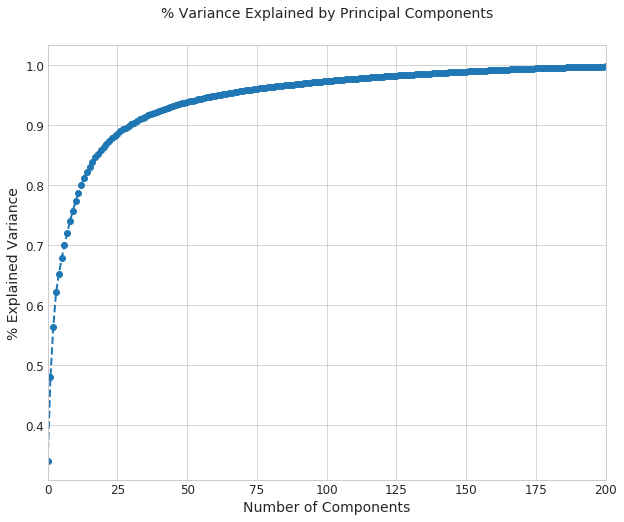

In [65]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [69]:
pca=PCA(n_components=65,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 65 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 65 components is: 0.952643777118


In [70]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [71]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [73]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,65).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.895780639227
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26538  3163    29701
True         463  4628     5091
__all__    27001  7791    34792

Accuracy of the KNN model for twst data is: 0.891711690999
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6608   805     7413
True         137  1149     1286
__all__     6745  1954     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883363991722
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26319  3382    29701
True         676  4415     5091
__all__    26995  7797    34792

Accuracy of the Logistic Regression model for twst data is: 0.882860098862
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6579   834     7413
True         185  1101     1286
__all__     6764  1935     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.906444010117
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26608  3093    29701
True         162  4929     5091
__all__    26770  8022    34792

Accuracy of the Random Forest Classifier for twst data is: 0.896080009196
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6639   774     7413
True         130  1156     1286
__all__     6769  1930     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.885979535525
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26437  3264    29701
True         703  4388     5091
__all__    27140  7652    34792

Accuracy of the Ada Boost Classifier for twst data is: 0.884929302219
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6604   809     7413
True         192  1094     1286
__all__     6796  1903     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.895062083238
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26613  3088    29701
True         563  4528     5091
__all__    27176  7616    34792

Accuracy of the Gradient Boosting Classifier for twst data is: 0.891711690999
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6639   774     7413
True         168  1118     1286
__all__     6807  1892     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.90839848241
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26611  3090    29701
True          97  4994     5091
__all__    26708  8084    34792

Accuracy of the Extra Tree Classifier for twst data is: 0.896654787907
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6638   775     7413
True         124  1162     1286
__all__     6762  1937     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.906472752357
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26600  3101    29701
True         153  4938     5091
__all__    26753  8039    34792

Accuracy of the Bagging model for twst data is: 0.896769743649
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6632   781     7413
True         117  1169     1286
__all__     6749  1950     8699



Neural Network-1
The accuracy of the model on training data is: 0.901816509542


Predicted  False  True  __all__
Actual                         
False      26404  3297    29701
True         119  4972     5091
__all__    26523  8269    34792

The accuracy of the model on test data is: 0.888148062996


Predicted  False  True  __all__
Actual                         
False       6544   869     7413
True         104  1182     1286
__all__     6648  2051     8699

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [74]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [75]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.895781,4628.0,26538.0,3163.0,463.0,0.106495,0.090945
LogisticRegression,0.883364,4415.0,26319.0,3382.0,676.0,0.113868,0.132783
RandomForestClassifier,0.906444,4929.0,26608.0,3093.0,162.0,0.104138,0.031821
AdaBoostClassifier,0.885980,4388.0,26437.0,3264.0,703.0,0.109895,0.138087
GradientBoostingClassifier,0.895062,4528.0,26613.0,3088.0,563.0,0.103970,0.110587
ExtraTreeClassifier,0.908398,4994.0,26611.0,3090.0,97.0,0.104037,0.019053
BaggingClassifier,0.906473,4938.0,26600.0,3101.0,153.0,0.104407,0.030053
Neural Network-1,0.901817,4972.0,26404.0,3297.0,119.0,0.111006,0.023375


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.891712,1149.0,6608.0,805.0,137.0,0.108593,0.106532,0.892438
LogisticRegression,0.882860,1101.0,6579.0,834.0,185.0,0.112505,0.143857,0.871819
RandomForestClassifier,0.896080,1156.0,6639.0,774.0,130.0,0.104411,0.101089,0.897250
AdaBoostClassifier,0.884929,1094.0,6604.0,809.0,192.0,0.109133,0.149300,0.870784
GradientBoostingClassifier,0.891712,1118.0,6639.0,774.0,168.0,0.104411,0.130638,0.882476
ExtraTreeClassifier,0.896655,1162.0,6638.0,775.0,124.0,0.104546,0.096423,0.899515
BaggingClassifier,0.896770,1169.0,6632.0,781.0,117.0,0.105355,0.090980,0.901832
Neural Network-1,0.888148,1182.0,6544.0,869.0,104.0,0.117226,0.080871,0.901832


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [77]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,65).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [78]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['a_count',
 'a_href_.aspx',
 'a_href_.com',
 'a_href_.htm',
 'a_href_.html',
 'a_href_.pdf',
 'a_href_.php',
 'a_href_0',
 'a_href_absolute',
 'a_href_http',
 'a_href_https',
 'a_href_mailto',
 'a_href_out_of_domain',
 'a_href_relative',
 'a_href_script_javascript',
 'a_rel_nofollow',
 'article_count',
 'aside_count',
 'b_count',
 'base_count',
 'base_href_absolute',
 'base_href_out_of_domain',
 'base_href_relative',
 'br_count',
 'button_count',
 'center_count',
 'dd_count',
 'div_count',
 'dl_count',
 'dt_count',
 'em_count',
 'fieldset_count',
 'figure_count',
 'font_count',
 'footer_count',
 'form_action_.php',
 'form_action_absolute',
 'form_action_http',
 'form_action_https',
 'form_action_out_of_domain',
 'form_action_relative',
 'form_count',
 'form_enctype_application/x-www-form-urlencoded',
 'h1_count',
 'header_count',
 'hr_count',
 'i_count',
 'iframe_count',
 'iframe_sandbox_allow_same_origin_count',
 'iframe_sandbox_allow_scripts_count',
 'iframe_src_.com',
 'iframe_src_

In [79]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [80]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [81]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.927546966534
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26129   3573    29702
True         731  28971    29702
__all__    26860  32544    59404

Accuracy of the KNN model for twst data is: 0.876767444534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6435   977     7412
True          95  1192     1287
__all__     6530  2169     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.894906066932
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24832   4870    29702
True        1373  28329    29702
__all__    26205  33199    59404

Accuracy of the Logistic Regression model for twst data is: 0.854810897804
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6211  1201     7412
True          62  1225     1287
__all__     6273  2426     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.94934684533
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27022   2680    29702
True         329  29373    29702
__all__    27351  32053    59404

Accuracy of the Random Forest Classifier for twst data is: 0.908725140821
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6729   683     7412
True         111  1176     1287
__all__     6840  1859     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.905898592687
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25408   4294    29702
True        1296  28406    29702
__all__    26704  32700    59404

Accuracy of the Ada Boost Classifier for twst data is: 0.868490631107
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6352  1060     7412
True          84  1203     1287
__all__     6436  2263     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.925611069962
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26188   3514    29702
True         905  28797    29702
__all__    27093  32311    59404

Accuracy of the Gradient Boosting Classifier for twst data is: 0.890332222094
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6552   860     7412
True          94  1193     1287
__all__     6646  2053     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.949986532893
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27025   2677    29702
True         294  29408    29702
__all__    27319  32085    59404

Accuracy of the Extra Tree Classifier for twst data is: 0.909070008047
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6735   677     7412
True         114  1173     1287
__all__     6849  1850     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.949414180863
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27017   2685    29702
True         320  29382    29702
__all__    27337  32067    59404

Accuracy of the Bagging model for twst data is: 0.906770893206
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6712   700     7412
True         111  1176     1287
__all__     6823  1876     8699



Neural Network-1
The accuracy of the model on training data is: 0.941300249141


Predicted  False   True  __all__
Actual                          
False      26590   3112    29702
True         375  29327    29702
__all__    26965  32439    59404

The accuracy of the model on test data is: 0.894355673066


Predicted  False  True  __all__
Actual                         
False       6595   817     7412
True         102  1185     1287
__all__     6697  2002     8699

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [82]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [83]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.927547,28971.0,26129.0,3573.0,731.0,0.120295,0.024611
LogisticRegression,0.894906,28329.0,24832.0,4870.0,1373.0,0.163962,0.046226
RandomForestClassifier,0.949347,29373.0,27022.0,2680.0,329.0,0.090230,0.011077
AdaBoostClassifier,0.905899,28406.0,25408.0,4294.0,1296.0,0.144569,0.043633
GradientBoostingClassifier,0.925611,28797.0,26188.0,3514.0,905.0,0.118309,0.030469
ExtraTreeClassifier,0.949987,29408.0,27025.0,2677.0,294.0,0.090129,0.009898
BaggingClassifier,0.949414,29382.0,27017.0,2685.0,320.0,0.090398,0.010774
Neural Network-1,0.941300,29327.0,26590.0,3112.0,375.0,0.104774,0.012625


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.876767,1192.0,6435.0,977.0,95.0,0.131813,0.073815,0.897186
LogisticRegression,0.854811,1225.0,6211.0,1201.0,62.0,0.162035,0.048174,0.894896
RandomForestClassifier,0.908725,1176.0,6729.0,683.0,111.0,0.092148,0.086247,0.910803
AdaBoostClassifier,0.868491,1203.0,6352.0,1060.0,84.0,0.143011,0.065268,0.895860
GradientBoostingClassifier,0.890332,1193.0,6552.0,860.0,94.0,0.116028,0.073038,0.905467
ExtraTreeClassifier,0.909070,1173.0,6735.0,677.0,114.0,0.091338,0.088578,0.910042
BaggingClassifier,0.906771,1176.0,6712.0,700.0,111.0,0.094441,0.086247,0.909656
Neural Network-1,0.894356,1185.0,6595.0,817.0,102.0,0.110227,0.079254,0.909656


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [84]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [85]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12754, 1467)


,index,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_absolute,a_href_ftp,a_href_http,a_href_https,a_href_irc,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,...,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,progress_count,q_count,s_count,samp_count,script_async_true,sc

In [86]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [87]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [88]:
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['a_count',
 'a_href_.aspx',
 'a_href_.com',
 'a_href_.htm',
 'a_href_.html',
 'a_href_.pdf',
 'a_href_.php',
 'a_href_0',
 'a_href_absolute',
 'a_href_http',
 'a_href_https',
 'a_href_mailto',
 'a_href_out_of_domain',
 'a_href_relative',
 'a_href_script_javascript',
 'a_rel_nofollow',
 'article_count',
 'aside_count',
 'b_count',
 'base_count',
 'base_href_absolute',
 'base_href_out_of_domain',
 'base_href_relative',
 'br_count',
 'button_count',
 'center_count',
 'dd_count',
 'div_count',
 'dl_count',
 'dt_count',
 'em_count',
 'fieldset_count',
 'figure_count',
 'font_count',
 'footer_count',
 'form_action_.php',
 'form_action_absolute',
 'form_action_http',
 'form_action_https',
 'form_action_out_of_domain',
 'form_action_relative',
 'form_count',
 'form_enctype_application/x-www-form-urlencoded',
 'h1_count',
 'header_count',
 'hr_count',
 'i_count',
 'iframe_count',
 'iframe_sandbox_allow_same_origin_count',
 'iframe_sandbox_allow_scripts_count',
 'iframe_src_.com',
 'iframe_src_

In [89]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.910026462805
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4481   667     5148
True         251  4804     5055
__all__     4732  5471    10203

Accuracy of the KNN model for twst data is: 0.898863190906
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1050   179     1229
True          79  1243     1322
__all__     1129  1422     2551



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.894638831716
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4314   834     5148
True         241  4814     5055
__all__     4555  5648    10203

Accuracy of the Logistic Regression model for twst data is: 0.898863190906
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1043   186     1229
True          72  1250     1322
__all__     1115  1436     2551



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.948446535333
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4684   464     5148
True          62  4993     5055
__all__     4746  5457    10203

Accuracy of the Random Forest Classifier for twst data is: 0.921599372795
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1114   115     1229
True          85  1237     1322
__all__     1199  1352     2551



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.895226894051
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4363   785     5148
True         284  4771     5055
__all__     4647  5556    10203

Accuracy of the Ada Boost Classifier for twst data is: 0.911015288122
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1074   155     1229
True          72  1250     1322
__all__     1146  1405     2551



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.913064784867
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4498   650     5148
True         237  4818     5055
__all__     4735  5468    10203

Accuracy of the Gradient Boosting Classifier for twst data is: 0.91023128185
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1087   142     1229
True          87  1235     1322
__all__     1174  1377     2551



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.950210722337
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4685   463     5148
True          45  5010     5055
__all__     4730  5473    10203

Accuracy of the Extra Tree Classifier for twst data is: 0.918071344571
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1118   111     1229
True          98  1224     1322
__all__     1216  1335     2551



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.946290306773
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4678   470     5148
True          78  4977     5055
__all__     4756  5447    10203

Accuracy of the Bagging model for twst data is: 0.917287338299
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1105   124     1229
True          87  1235     1322
__all__     1192  1359     2551



Neural Network-1
The accuracy of the model on training data is: 0.940997745779


Predicted  False  True  __all__
Actual                         
False       4625   523     5148
True          79  4976     5055
__all__     4704  5499    10203

The accuracy of the model on test data is: 0.918071344571


Predicted  False  True  __all__
Actual                         
False       1094   135     1229
True          74  1248     1322
__all__     1168  1383     2551

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [90]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [91]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.910026,4804.0,4481.0,667.0,251.0,0.129565,0.049654
LogisticRegression,0.894639,4814.0,4314.0,834.0,241.0,0.162005,0.047676
RandomForestClassifier,0.948447,4993.0,4684.0,464.0,62.0,0.090132,0.012265
AdaBoostClassifier,0.895227,4771.0,4363.0,785.0,284.0,0.152486,0.056182
GradientBoostingClassifier,0.913065,4818.0,4498.0,650.0,237.0,0.126263,0.046884
ExtraTreeClassifier,0.950211,5010.0,4685.0,463.0,45.0,0.089938,0.008902
BaggingClassifier,0.946290,4977.0,4678.0,470.0,78.0,0.091298,0.015430
Neural Network-1,0.940998,4976.0,4625.0,523.0,79.0,0.101593,0.015628


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.898863,1243.0,1050.0,179.0,79.0,0.145647,0.059758,0.897298
LogisticRegression,0.898863,1250.0,1043.0,186.0,72.0,0.151343,0.054463,0.897097
RandomForestClassifier,0.921599,1237.0,1114.0,115.0,85.0,0.093572,0.064297,0.921066
AdaBoostClassifier,0.911015,1250.0,1074.0,155.0,72.0,0.126119,0.054463,0.909709
GradientBoostingClassifier,0.910231,1235.0,1087.0,142.0,87.0,0.115541,0.065809,0.909325
ExtraTreeClassifier,0.918071,1224.0,1118.0,111.0,98.0,0.090317,0.074130,0.917776
BaggingClassifier,0.917287,1235.0,1105.0,124.0,87.0,0.100895,0.065809,0.916648
Neural Network-1,0.918071,1248.0,1094.0,135.0,74.0,0.109845,0.055976,0.916648


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [92]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [93]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')